### 🖼️ FIGURAS

In [28]:
import os
import warnings
import numpy as np
import pandas as pd
from tqdm import tqdm
from matplotlib import pyplot as plt
from sklearn import linear_model, model_selection
import pickle

# Suppress warnings and TensorFlow logs
warnings.simplefilter(action="ignore")
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, losses, optimizers, metrics
from tensorflow.python.client import device_lib

import keras_cv as kcv
from keras_cv import visualization
from keras_cv.models import ResNet18Backbone

In [29]:
def set_device(mixed_precision=True, set_jit=False):
    # printed out the detected devices
    list_ld = device_lib.list_local_devices()
    for dev in list_ld:
        print(dev.name,dev.memory_limit)

    # get the lisf of physical devices
    physical_devices = tf.config.list_physical_devices(
        'GPU' if len(list_ld) - 1 else 'CPU'
    )
    # For GPU devices, configure related stuff
    if 'GPU' in physical_devices[-1]:
        tf.config.optimizer.set_jit(set_jit)
        if mixed_precision:
            keras.mixed_precision.set_global_policy(
                "mixed_float16"
            )
        else:
            keras.mixed_precision.set_global_policy(
                keras.backend.floatx()
            )
        for pd in physical_devices:
            tf.config.experimental.set_memory_growth(
                pd, True
            )
    strategy = tf.distribute.MirroredStrategy()
    return (strategy, physical_devices)

In [30]:
strategy, physical_devices = set_device(mixed_precision=True, set_jit=True)
physical_devices, strategy, tf.__version__

/device:CPU:0 268435456
/device:GPU:0 4254072832
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


([PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')],
 '2.15.1')

### 🖼️ Modelo base ResNet18

In [31]:
# Getting back the objects:
with open('../base.pkl', 'rb') as f:
    [history, test_losses, train_losses, forget_losses, rt_test_losses, rt_forget_losses, mia_scores, rt_mia_scores] = pickle.load(f) 


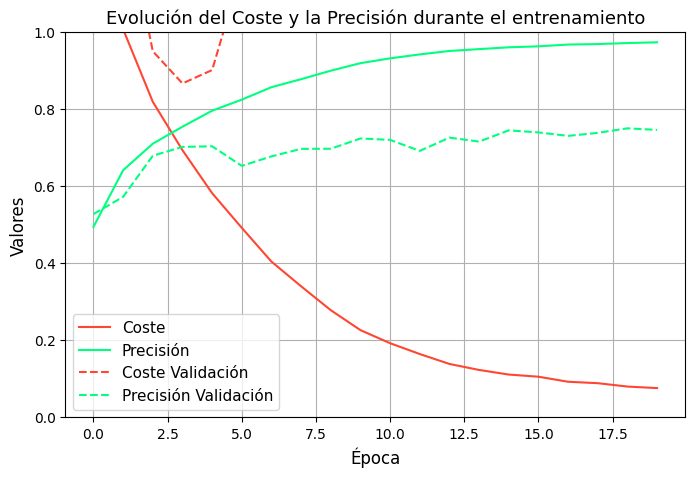

In [15]:

# Graficar el DataFrame
grafica = pd.DataFrame(history.history)
grafica.plot(figsize=(8,5))

# Configurar propiedades
plt.grid(True)
plt.gca().set_ylim(0,1)
# plt.gca().set_xlim(0,20)
plt.xlabel('Época', fontsize=12)
plt.ylabel('Valores', fontsize=12)

plt.gca().get_lines()[0].set_color('#ff4633')
plt.gca().get_lines()[1].set_color('springgreen')
plt.gca().get_lines()[2].set_color('#ff4633')
plt.gca().get_lines()[3].set_color('springgreen')

plt.gca().get_lines()[2].set_linestyle('--')
plt.gca().get_lines()[3].set_linestyle('--')

plt.legend(['Coste', 'Precisión', 'Coste Validación', 'Precisión Validación'], fontsize=11)
plt.title('Evolución del Coste y la Precisión durante el entrenamiento', fontsize=13)

# Guardar la figura como un archivo PNG
plt.savefig('base/evolucion_entrenamiento.png', bbox_inches='tight')

plt.show()

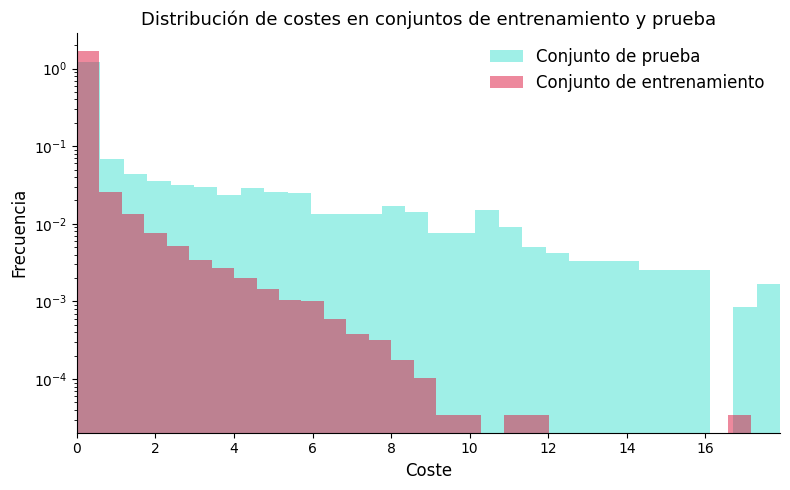

In [36]:
# Crear el gráfico
plt.figure(figsize=(8, 5))

# Histogramas de costes para el conjunto de entrenamiento y prueba
plt.hist(test_losses, density=True, alpha=0.5, bins=30, label="Conjunto de prueba", color='turquoise')
plt.hist(train_losses, density=True, alpha=0.5, bins=30, label="Conjunto de entrenamiento", color='crimson')

# Título y etiquetas de ejes
plt.title("Distribución de costes en conjuntos de entrenamiento y prueba", fontsize=13)
plt.xlabel("Coste", fontsize=12)
plt.ylabel("Frecuencia", fontsize=12)

# Límites y escala logarítmica en el eje y
plt.xlim((0, max(np.max(test_losses), np.max(train_losses))))
plt.yscale("log")

# Leyenda sin marco
plt.legend(frameon=False, fontsize=12)

# Quitar bordes superior y derecho
ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Mostrar el gráfico
plt.tight_layout()
plt.savefig('base/distribucion_costes.png', bbox_inches='tight')
plt.show()

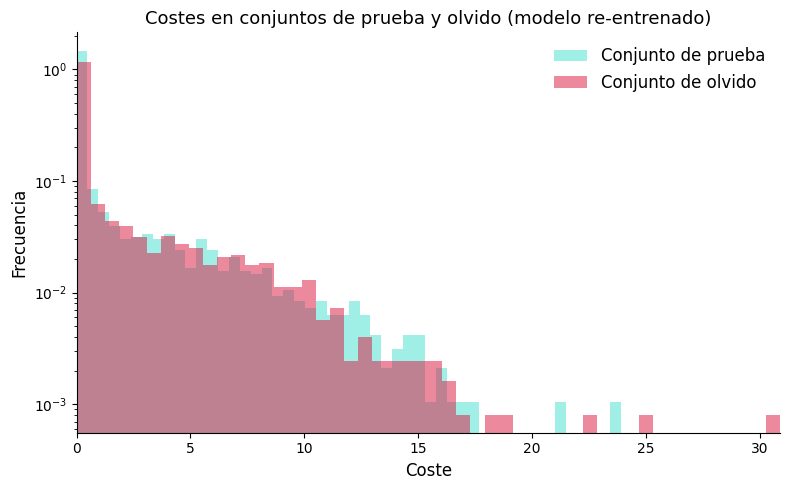

In [37]:
# Crear el gráfico
plt.figure(figsize=(8, 5))

# Histogramas de pérdidas para el conjunto de prueba y olvidado
plt.hist(rt_test_losses, density=True, alpha=0.5, bins=50, label="Conjunto de prueba", color='turquoise')
plt.hist(rt_forget_losses, density=True, alpha=0.5, bins=50, label="Conjunto de olvido", color='crimson')

# Título y etiquetas de ejes
plt.title("Costes en conjuntos de prueba y olvido (modelo re-entrenado)", fontsize=13)
plt.xlabel("Coste", fontsize=12)
plt.ylabel("Frecuencia", fontsize=12)

# Límites y escala logarítmica en el eje y
plt.xlim((0, max(np.max(rt_test_losses), np.max(rt_forget_losses))))
plt.yscale("log")

# Leyenda sin marco
plt.legend(frameon=False, fontsize=12)

# Quitar bordes superior y derecho
ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Mostrar el gráfico
plt.tight_layout()

# Guardar el gráfico como archivo PNG
plt.savefig('base/distribucion_costes_olvido.png', bbox_inches='tight')

plt.show()

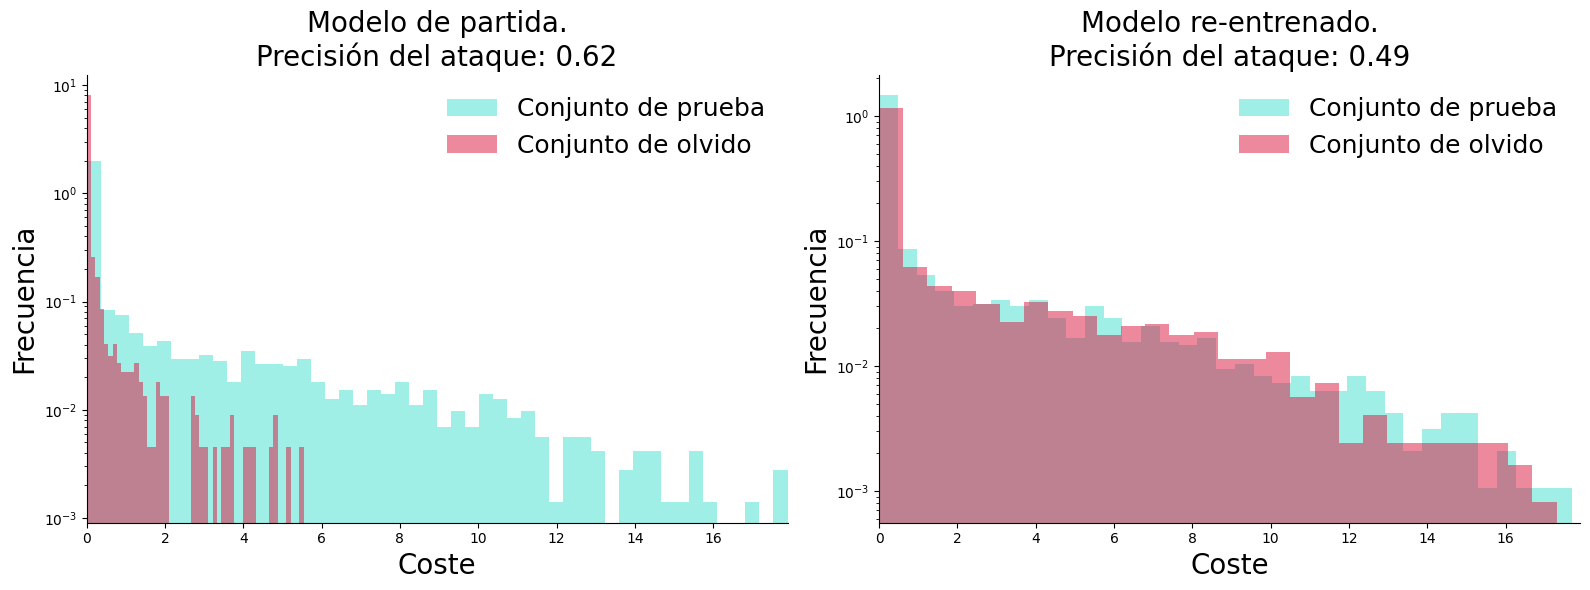

In [34]:
# Crear los subgráficos
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Subgráfico izquierdo
ax1.set_title(f"Modelo de partida.\nPrecisión del ataque: {mia_scores.mean():0.2f}", fontsize=20)
ax1.hist(test_losses, density=True, alpha=0.5, bins=50, label="Conjunto de prueba", color='turquoise')
ax1.hist(forget_losses, density=True, alpha=0.5, bins=50, label="Conjunto de olvido", color='crimson')
ax1.set_xlabel("Coste", fontsize=20)
ax1.set_ylabel("Frecuencia", fontsize=20)
ax1.set_yscale("log")
ax1.set_xlim((0, np.max(test_losses)))
ax1.legend(frameon=False, fontsize=18)
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)

# Subgráfico derecho
ax2.set_title(f"Modelo re-entrenado.\nPrecisión del ataque: {rt_mia_scores.mean():0.2f}", fontsize=20)
ax2.hist(rt_test_losses, density=True, alpha=0.5, bins=50, label="Conjunto de prueba", color='turquoise')
ax2.hist(rt_forget_losses, density=True, alpha=0.5, bins=50, label="Conjunto de olvido", color='crimson')
ax2.set_xlabel("Coste", fontsize=20)
ax2.set_ylabel("Frecuencia", fontsize=20)
ax2.set_yscale("log")
ax2.set_xlim((0, np.max(test_losses)))
ax2.legend(frameon=False, fontsize=18)
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)

# Ajustar el diseño y mostrar el gráfico
plt.tight_layout()

# Guardar el gráfico como archivo PNG
plt.savefig('base/distribucion_costes_ambos.png', bbox_inches='tight')

plt.show()

### 🖼️ SIsA

In [9]:
# Getting back the objects:
with open('../SIsA_data.pkl', 'rb') as f:
    [slices, accuracy_train, accuracy_test, mia_score, slice_accuracy_test] = pickle.load(f) 

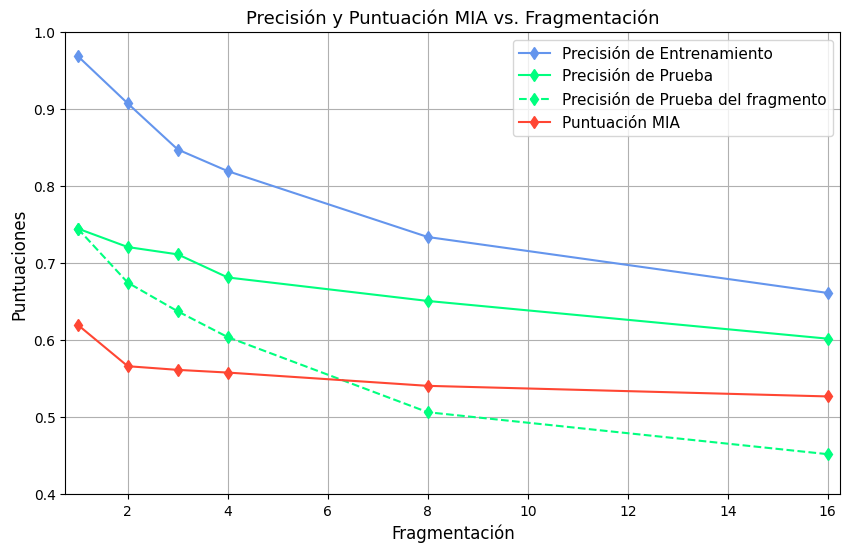

In [12]:
# Crear el gráfico
plt.figure(figsize=(10, 6))

# Líneas para las precisiones de entrenamiento y prueba, y la evaluación de privacidad
plt.plot(slices, accuracy_train, marker='d', linestyle='-', color='cornflowerblue', label='Precisión de Entrenamiento')
plt.plot(slices, accuracy_test, marker='d', linestyle='-', color='springgreen', label='Precisión de Prueba')
plt.plot(slices, slice_accuracy_test, marker='d', linestyle='--', color='springgreen', label='Precisión de Prueba del fragmento')
plt.plot(slices, mia_score, marker='d', linestyle='-', color='#ff4633', label='Puntuación MIA')

# Etiquetas de ejes y título
plt.xlabel('Fragmentación', fontsize=12)
plt.ylabel('Puntuaciones', fontsize=12)
plt.title('Precisión y Puntuación MIA vs. Fragmentación', fontsize=13)

# Leyenda y cuadrícula
plt.legend(fontsize=11)
plt.grid(True)

plt.ylim(0.4, 1)
plt.xlim(0.75, 16.25)

plt.savefig('SIsA/precision_evaluacion_privacidad.png', bbox_inches='tight')
plt.show()

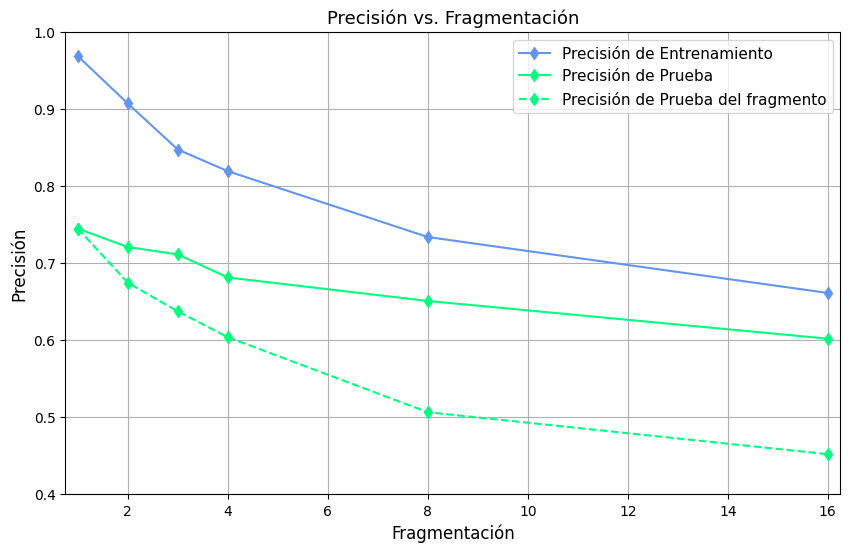

In [113]:
# Crear el gráfico
plt.figure(figsize=(10, 6))

# Líneas para las precisiones de entrenamiento y prueba, y la evaluación de privacidad
plt.plot(slices, accuracy_train, marker='d', linestyle='-', color='cornflowerblue', label='Precisión de Entrenamiento')
plt.plot(slices, accuracy_test, marker='d', linestyle='-', color='springgreen', label='Precisión de Prueba')
plt.plot(slices, slice_accuracy_test, marker='d', linestyle='--', color='springgreen', label='Precisión de Prueba del fragmento')

# Etiquetas de ejes y título
plt.xlabel('Fragmentación', fontsize=12)
plt.ylabel('Precisión', fontsize=12)
plt.title('Precisión vs. Fragmentación', fontsize=13)

# Leyenda y cuadrícula
plt.legend(fontsize=11)
plt.grid(True)

plt.ylim(0.4, 1)
plt.xlim(0.75, 16.25)

plt.savefig('SIsA/precision_evaluacion.png', bbox_inches='tight')
plt.show()

### 🖼️ SNIsA

In [5]:
# Getting back the objects:
with open('../SNIsA.pkl', 'rb') as f:
    [NIepochs, pre_accuracy_train, pre_accuracy_test, pre_mia_score, accuracy_train, accuracy_test, mia_score] = pickle.load(f)

NNIepochs=[20-n for n in NIepochs]

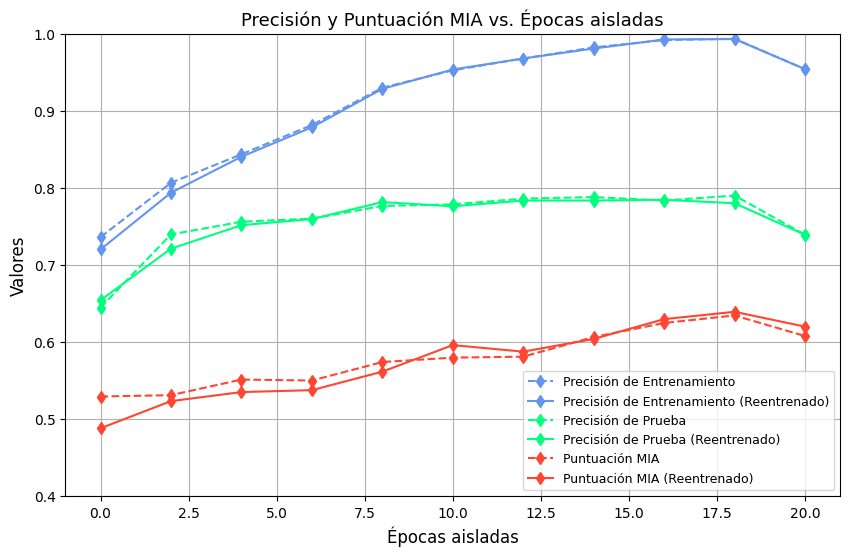

In [8]:
# Crear el gráfico
plt.figure(figsize=(10, 6))


plt.plot(NNIepochs, pre_accuracy_train, marker='d', linestyle='--', color='cornflowerblue', label='Precisión de Entrenamiento')
plt.plot(NNIepochs, accuracy_train, marker='d', linestyle='-', color='cornflowerblue', label='Precisión de Entrenamiento (Reentrenado)')

plt.plot(NNIepochs, pre_accuracy_test, marker='d', linestyle='--', color='springgreen', label='Precisión de Prueba')
plt.plot(NNIepochs, accuracy_test, marker='d', linestyle='-', color='springgreen', label='Precisión de Prueba (Reentrenado)')

plt.plot(NNIepochs, pre_mia_score, marker='d', linestyle='--', color='#ff4633', label='Puntuación MIA')
plt.plot(NNIepochs, mia_score, marker='d', linestyle='-', color='#ff4633', label='Puntuación MIA (Reentrenado)')

# Etiquetas de ejes y título
plt.xlabel('Épocas aisladas', fontsize=12)
plt.ylabel('Valores', fontsize=12)
plt.title('Precisión y Puntuación MIA vs. Épocas aisladas', fontsize=13)

# Leyenda y cuadrícula
plt.legend(fontsize=9)
plt.grid(True)

# Limitar el eje y entre 0.45 y 1 para una mejor visualización
plt.ylim(0.4, 1)

# Guardar el gráfico como archivo PNG
plt.savefig('SNIsA/precisión_y_puntuación_MIA.png', bbox_inches='tight')

# Mostrar el gráfico
plt.show()

### 🖼️ Depuración

In [14]:
# Getting back the objects:
with open('../UnConLa.pkl', 'rb') as f:
    [confusion_stds, accuracy_retain, accuracy_forget, accuracy_test, mia_score] = pickle.load(f)

In [15]:
# Convert to numpy arrays
accuracy_retain = np.array(accuracy_retain)
accuracy_forget = np.array(accuracy_forget)
accuracy_test = np.array(accuracy_test)
mia_score = np.array(mia_score)
confusion_stds = np.array(confusion_stds[0])  # Confusion STDs are the same for all three, so just take one

# Calculate means and standard deviations
retain_mean = np.mean(accuracy_retain, axis=0)
retain_std = np.std(accuracy_retain, axis=0)
forget_mean = np.mean(accuracy_forget, axis=0)
forget_std = np.std(accuracy_forget, axis=0)
test_mean = np.mean(accuracy_test, axis=0)
test_std = np.std(accuracy_test, axis=0)
mia_mean = np.mean(mia_score, axis=0)
mia_std = np.std(mia_score, axis=0)

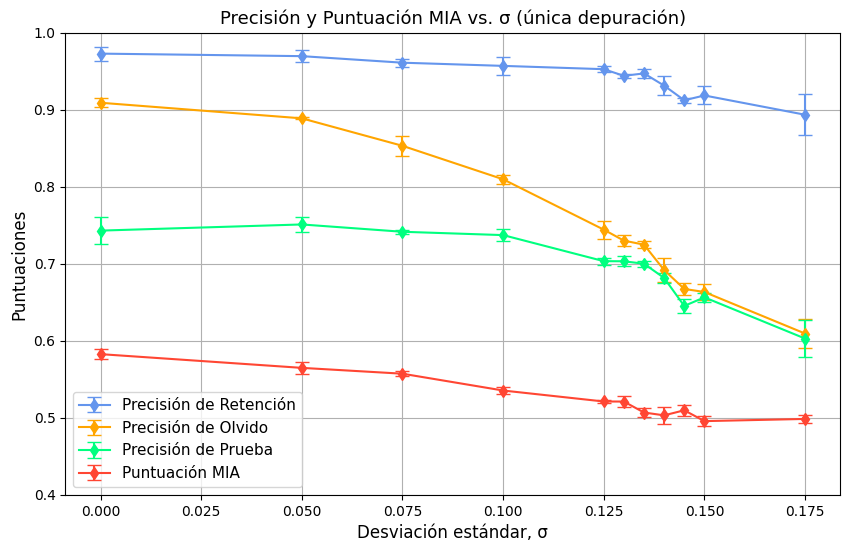

In [16]:
# Crear el gráfico
plt.figure(figsize=(10, 6))

# Líneas con barras de error
plt.errorbar(confusion_stds, retain_mean, yerr=retain_std, fmt='d-', label='Precisión de Retención', color='cornflowerblue', capsize=5)
plt.errorbar(confusion_stds, forget_mean, yerr=forget_std, fmt='d-', label='Precisión de Olvido', color='orange', capsize=5)
plt.errorbar(confusion_stds, test_mean, yerr=test_std, fmt='d-', label='Precisión de Prueba', color='springgreen', capsize=5)
plt.errorbar(confusion_stds, mia_mean, yerr=mia_std, fmt='d-', label='Puntuación MIA', color='#ff4633', capsize=5)

# Etiquetas de ejes y título
plt.xlabel('Desviación estándar, σ', fontsize=12)
plt.ylabel('Puntuaciones', fontsize=12)
plt.title('Precisión y Puntuación MIA vs. σ (única depuración)', fontsize=13)

# Leyenda y cuadrícula
plt.legend(fontsize=11)
plt.grid(True)

# Limitar el eje y entre 0.45 y 1 para una mejor visualización
plt.ylim(0.4, 1)

# Guardar el gráfico como archivo PNG
plt.savefig('depuracion/precisión_y_puntuación_MIA_vs_STD_1dep.png', bbox_inches='tight')

# Mostrar el gráfico
plt.show()

In [11]:
# Getting back the objects:
with open('../UnConLa_cycles.pkl', 'rb') as f:
    [confusion_stds_c, accuracy_retain_c, accuracy_forget_c, accuracy_test_c, mia_score_c] = pickle.load(f)

In [12]:
# Convert to numpy arrays
accuracy_retain_c = np.array(accuracy_retain_c)
accuracy_forget_c = np.array(accuracy_forget_c)
accuracy_test_c = np.array(accuracy_test_c)
mia_score_c = np.array(mia_score_c)
confusion_stds_c = np.array(confusion_stds_c[0])  # Confusion STDs are the same for all three, so just take one

# Calculate means and standard deviations
retain_mean_c = np.mean(accuracy_retain_c, axis=0)
retain_std_c = np.std(accuracy_retain_c, axis=0)
forget_mean_c = np.mean(accuracy_forget_c, axis=0)
forget_std_c = np.std(accuracy_forget_c, axis=0)
test_mean_c = np.mean(accuracy_test_c, axis=0)
test_std_c = np.std(accuracy_test_c, axis=0)
mia_mean_c = np.mean(mia_score_c, axis=0)
mia_std_c = np.std(mia_score_c, axis=0)

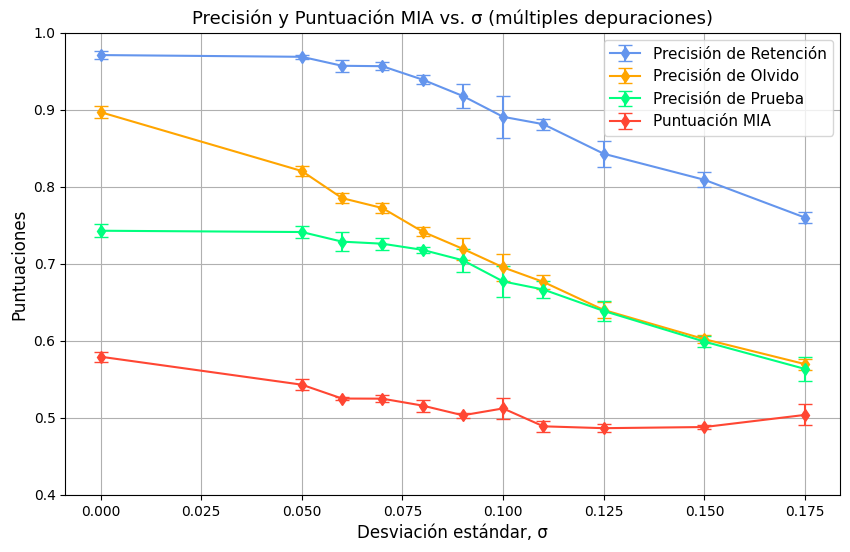

In [19]:
# Crear el gráfico
plt.figure(figsize=(10, 6))

# Líneas con barras de error
plt.errorbar(confusion_stds_c, retain_mean_c, yerr=retain_std_c, fmt='d-', label='Precisión de Retención', color='cornflowerblue', capsize=5)
plt.errorbar(confusion_stds_c, forget_mean_c, yerr=forget_std_c, fmt='d-', label='Precisión de Olvido', color='orange', capsize=5)
plt.errorbar(confusion_stds_c, test_mean_c, yerr=test_std_c, fmt='d-', label='Precisión de Prueba', color='springgreen', capsize=5)
plt.errorbar(confusion_stds_c, mia_mean_c, yerr=mia_std_c, fmt='d-', label='Puntuación MIA', color='#ff4633', capsize=5)

# Etiquetas de ejes y título
plt.xlabel('Desviación estándar, σ', fontsize=12)
plt.ylabel('Puntuaciones', fontsize=12)
plt.title('Precisión y Puntuación MIA vs. σ (múltiples depuraciones)', fontsize=13)

# Leyenda y cuadrícula
plt.legend(fontsize=11)
plt.grid(True)

# Limitar el eje y entre 0.45 y 1 para una mejor visualización
plt.ylim(0.4, 1)

# Guardar el gráfico como archivo PNG
plt.savefig('depuracion/precisión_y_puntuación_MIA_vs_STD_6dep.png', bbox_inches='tight')

# Mostrar el gráfico
plt.show()

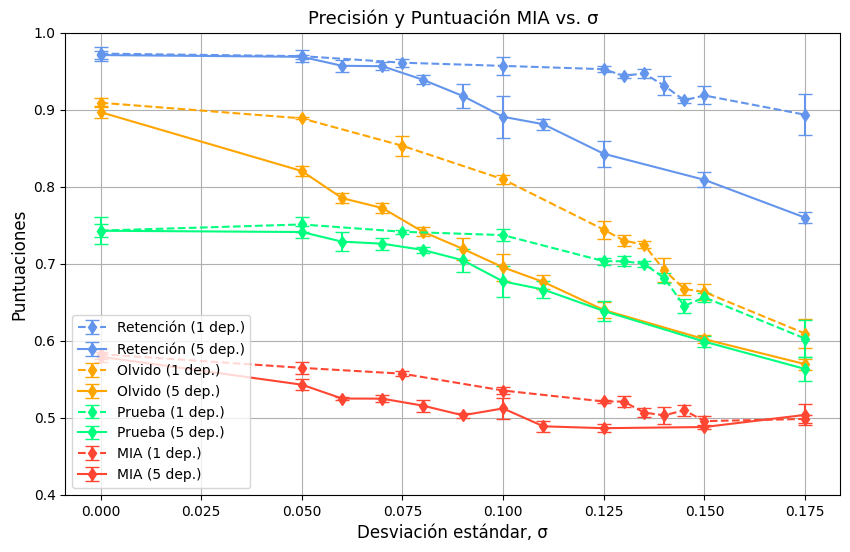

In [20]:
# Crear el gráfico
plt.figure(figsize=(10, 6))

# Líneas con barras de error
plt.errorbar(confusion_stds, retain_mean, yerr=retain_std, fmt='d--', label='Retención (1 dep.)', color='cornflowerblue', capsize=5)
plt.errorbar(confusion_stds_c, retain_mean_c, yerr=retain_std_c, fmt='d-', label='Retención (5 dep.)', color='cornflowerblue', capsize=5)

plt.errorbar(confusion_stds, forget_mean, yerr=forget_std, fmt='d--', label='Olvido (1 dep.)', color='orange', capsize=5)
plt.errorbar(confusion_stds_c, forget_mean_c, yerr=forget_std_c, fmt='d-', label='Olvido (5 dep.)', color='orange', capsize=5)

plt.errorbar(confusion_stds, test_mean, yerr=test_std, fmt='d--', label='Prueba (1 dep.)', color='springgreen', capsize=5)
plt.errorbar(confusion_stds_c, test_mean_c, yerr=test_std_c, fmt='d-', label='Prueba (5 dep.)', color='springgreen', capsize=5)

plt.errorbar(confusion_stds, mia_mean, yerr=mia_std, fmt='d--', label='MIA (1 dep.)', color='#ff4633', capsize=5)
plt.errorbar(confusion_stds_c, mia_mean_c, yerr=mia_std_c, fmt='d-', label='MIA (5 dep.)', color='#ff4633', capsize=5)


# Etiquetas de ejes y título
plt.xlabel('Desviación estándar, σ', fontsize=12)
plt.ylabel('Puntuaciones', fontsize=12)
plt.title('Precisión y Puntuación MIA vs. σ', fontsize=13)

# Leyenda y cuadrícula
plt.legend(fontsize=10)
plt.grid(True)

# Limitar el eje y entre 0.45 y 1 para una mejor visualización
plt.ylim(0.4, 1)

# Guardar el gráfico como archivo PNG
plt.savefig('depuracion/precisión_y_puntuación_MIA_vs_STD.png', bbox_inches='tight')

# Mostrar el gráfico
plt.show()

### 🖼️ Depuración sliced

In [5]:
# Getting back the objects:
with open('../UnConLa_sliced.pkl', 'rb') as f:  # Python 3: open(..., 'rb')
    [confusion_stds, accuracy_retain, accuracy_forget, accuracy_test, mia_score] = pickle.load(f)

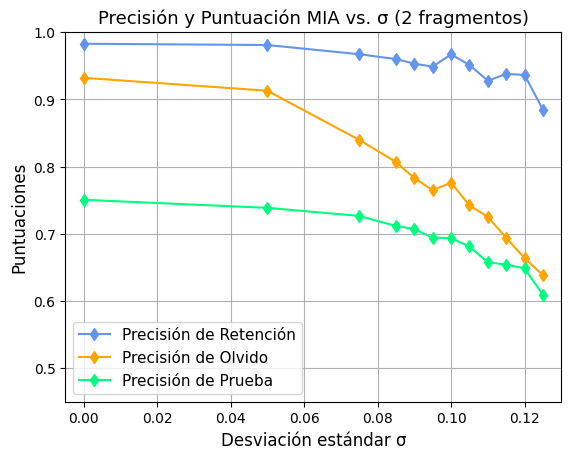

In [6]:
plt.plot(confusion_stds[0], accuracy_retain[0], 'd-', label='Precisión de Retención', color='cornflowerblue')
plt.plot(confusion_stds[0], accuracy_forget[0], 'd-', label='Precisión de Olvido', color='orange')
plt.plot(confusion_stds[0], accuracy_test[0], 'd-', label='Precisión de Prueba', color='springgreen')

# Etiquetas de ejes y título
plt.xlabel('Desviación estándar σ', fontsize=12)
plt.ylabel('Puntuaciones', fontsize=12)
plt.title('Precisión y Puntuación MIA vs. σ (2 fragmentos)', fontsize=13)

# Leyenda y cuadrícula
plt.legend(fontsize=11)
plt.grid(True)

# Limitar el eje y entre 0.45 y 1 para una mejor visualización
plt.ylim(0.45, 1)
plt.xlim(-0.005, 0.13)

# Guardar el gráfico como archivo PNG
plt.savefig('depuracion/precisión_y_puntuación_MIA_vs_STD_2_fragmentos.png', bbox_inches='tight')

# Mostrar el gráfico
plt.show()

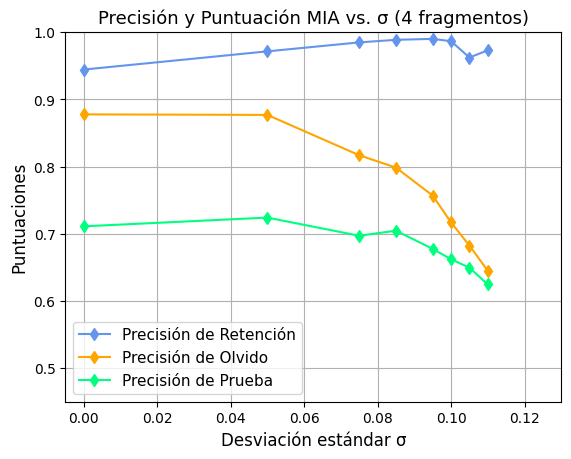

In [7]:
plt.plot(confusion_stds[1], accuracy_retain[1], 'd-', label='Precisión de Retención', color='cornflowerblue')
plt.plot(confusion_stds[1], accuracy_forget[1], 'd-', label='Precisión de Olvido', color='orange')
plt.plot(confusion_stds[1], accuracy_test[1], 'd-', label='Precisión de Prueba', color='springgreen')

# Etiquetas de ejes y título
plt.xlabel('Desviación estándar σ', fontsize=12)
plt.ylabel('Puntuaciones', fontsize=12)
plt.title('Precisión y Puntuación MIA vs. σ (4 fragmentos)', fontsize=13)

# Leyenda y cuadrícula
plt.legend(fontsize=11)
plt.grid(True)

# Limitar el eje y entre 0.45 y 1 para una mejor visualización
plt.ylim(0.45, 1)
plt.xlim(-0.005, 0.13)

# Guardar el gráfico como archivo PNG
plt.savefig('depuracion/precisión_y_puntuación_MIA_vs_STD_4_fragmentos.png', bbox_inches='tight')

# Mostrar el gráfico
plt.show()

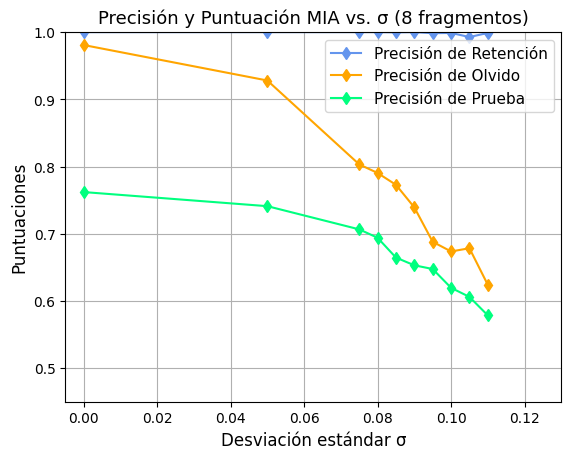

In [8]:
plt.plot(confusion_stds[2], accuracy_retain[2], 'd-', label='Precisión de Retención', color='cornflowerblue')
plt.plot(confusion_stds[2], accuracy_forget[2], 'd-', label='Precisión de Olvido', color='orange')
plt.plot(confusion_stds[2], accuracy_test[2], 'd-', label='Precisión de Prueba', color='springgreen')

# Etiquetas de ejes y título
plt.xlabel('Desviación estándar σ', fontsize=12)
plt.ylabel('Puntuaciones', fontsize=12)
plt.title('Precisión y Puntuación MIA vs. σ (8 fragmentos)', fontsize=13)

# Leyenda y cuadrícula
plt.legend(fontsize=11)
plt.grid(True)

# Limitar el eje y entre 0.45 y 1 para una mejor visualización
plt.ylim(0.45, 1)
plt.xlim(-0.005, 0.13)

# Guardar el gráfico como archivo PNG
plt.savefig('depuracion/precisión_y_puntuación_MIA_vs_STD_8_fragmentos.png', bbox_inches='tight')

# Mostrar el gráfico
plt.show()

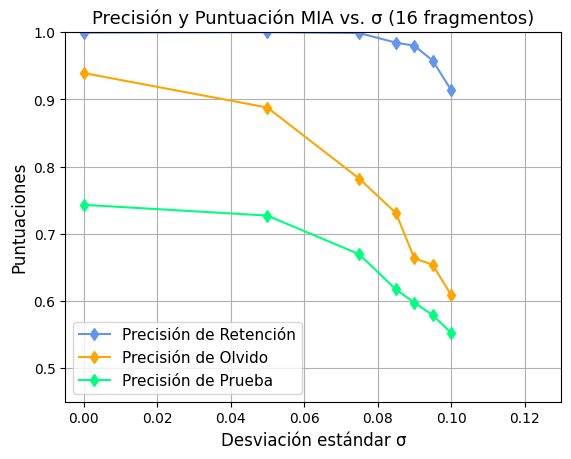

In [10]:
""" confusion_stds[3].pop()
accuracy_retain[3].pop()
accuracy_forget[3].pop()
accuracy_test[3].pop() """

plt.plot(confusion_stds[3], accuracy_retain[3], 'd-', label='Precisión de Retención', color='cornflowerblue')
plt.plot(confusion_stds[3], accuracy_forget[3], 'd-', label='Precisión de Olvido', color='orange')
plt.plot(confusion_stds[3], accuracy_test[3], 'd-', label='Precisión de Prueba', color='springgreen')

# Etiquetas de ejes y título
plt.xlabel('Desviación estándar σ', fontsize=12)
plt.ylabel('Puntuaciones', fontsize=12)
plt.title('Precisión y Puntuación MIA vs. σ (16 fragmentos)', fontsize=13)

# Leyenda y cuadrícula
plt.legend(fontsize=11)
plt.grid(True)

# Limitar el eje y entre 0.45 y 1 para una mejor visualización
plt.ylim(0.45, 1)
plt.xlim(-0.005, 0.13)

# Guardar el gráfico como archivo PNG
plt.savefig('depuracion/precisión_y_puntuación_MIA_vs_STD_16_fragmentos.png', bbox_inches='tight')

# Mostrar el gráfico
plt.show()

### 🖼️ SNIsA & Depuración

In [19]:
# Getting back the objects:
with open('../SNIsA_unconla.pkl', 'rb') as f:
    [confusion_stds, accuracy_retain, accuracy_forget, accuracy_test, mia_score] = pickle.load(f)

In [20]:
confusion_stds[0]=confusion_stds[0][0]
accuracy_retain[0]=accuracy_retain[0][0]
accuracy_forget[0]=accuracy_forget[0][0]
accuracy_test[0]=accuracy_test[0][0]
mia_score[0]=mia_score[0][0]

confusion_stds[1]=confusion_stds[1][0]
accuracy_retain[1]=accuracy_retain[1][0]
accuracy_forget[1]=accuracy_forget[1][0]
accuracy_test[1]=accuracy_test[1][0]
mia_score[1]=mia_score[1][0]

confusion_stds[2]=confusion_stds[2][0]
accuracy_retain[2]=accuracy_retain[2][0]
accuracy_forget[2]=accuracy_forget[2][0]
accuracy_test[2]=accuracy_test[2][0]
mia_score[2]=mia_score[2][0]

confusion_stds[3]=confusion_stds[3][1]
accuracy_retain[3]=accuracy_retain[3][1]
accuracy_forget[3]=accuracy_forget[3][1]
accuracy_test[3]=accuracy_test[3][1]
mia_score[3]=mia_score[3][1]

confusion_stds=[0.09]+confusion_stds
accuracy_retain=[0.9178296327590942]+accuracy_retain
accuracy_forget=[0.7193333307902018]+accuracy_forget
accuracy_test=[0.7045000195503235]+accuracy_test
mia_score=[0.5031666666666667]+mia_score

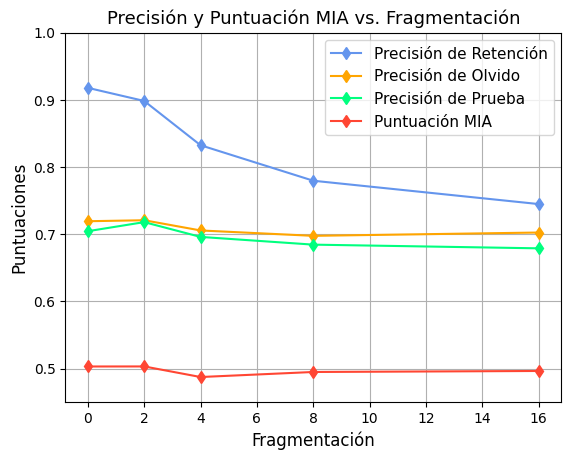

In [23]:
slices=[0,2,4,8,16]

plt.plot(slices, accuracy_retain, 'd-', label='Precisión de Retención', color='cornflowerblue')
plt.plot(slices, accuracy_forget, 'd-', label='Precisión de Olvido', color='orange')
plt.plot(slices, accuracy_test, 'd-', label='Precisión de Prueba', color='springgreen')
plt.plot(slices, mia_score, 'd-', label='Puntuación MIA', color='#ff4633')

# Etiquetas de ejes y título
plt.xlabel('Fragmentación', fontsize=12)
plt.ylabel('Puntuaciones', fontsize=12)
plt.title('Precisión y Puntuación MIA vs. Fragmentación', fontsize=13)

# Leyenda y cuadrícula
plt.legend(fontsize=11)
plt.grid(True)

# Limitar el eje y entre 0.45 y 1 para una mejor visualización
plt.ylim(0.45, 1)

# Guardar el gráfico como archivo PNG
plt.savefig('SNIsA_y_depuracion.png', bbox_inches='tight')

# Mostrar el gráfico
plt.show()